In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate
import scipy.stats as sc_stats

from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations



### Read `ods` to `DataFrame`

In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [4]:
def get_multiple_regress_coeff(df, n_vars=2):
  
  num_of_samples = len(df)
  X_arr = np.zeros((num_of_samples, n_vars))
  Y = df["Y"].to_numpy()

  for i in range(n_vars):
    key = f"X_{i+1}"
    X_arr[:, i] = df[key].to_numpy()

  regress = LinearRegression().fit(X_arr, Y)

  df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 

  return regress, df


### Get Minitab's output of Regression Analysis

In [39]:
def get_minitab_out(df, n_vars=2, new_column=None):
  """
  new_column (dict) : a dictionary mapping to rename df header
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars)
  b_arr = [regress.intercept_] + regress.coef_.tolist()

  # -- compute cofactor matrix 
  X_arr = np.ones_like(data_struct)
  X_arr[:,1:] = data_struct[:,1:]
  cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix

  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()
  s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  dof = num_of_samples - 2;          # degrees of freedom
  for i in range(1+n_vars):
    SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
    t_scores[i] = b_arr[i] / SE_coef[i]
    p_values[i] = sc_stats.t.pdf(t_scores[i], dof)

  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  SST = ((data_struct[:, 0] - meanY)**2).sum()
  SSR = ((hat_Y - meanY)**2).sum()
  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.pdf(anova_F_score, anova_dof[0], anova_dof[1])

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)

  # -- create tabular form for correlation 
  data = []
  for i in range(n_vars):
    data_row = [new_column[i+1], *corr_matrix[i,:]]
    data.append(data_row)

  table_corr = tabulate.tabulate(data, tablefmt='html', 
    headers=[""] + new_column[:n_vars], 
    floatfmt=[None] + [".2f"]*n_vars)

  print(f"Correlations: {', '.join(new_column)}")
  display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  for i in range(1, n_vars+1):
    data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
    data.append(data_row)

  # print(data)
  table_predictor = tabulate.tabulate(data, tablefmt='html', 
    headers=["Predictor", "Coef", "SE Coef", "T", "P"], 
    floatfmt=[None, ".4f", ".4f", ".2f", ".3f"])

  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  display(table_predictor)
  print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.3f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  return {"regress": regress, "corr_matrix": corr_matrix, 
    "R_sq": R_sq}


## Load the data

In [6]:
filename = "06-table-09-electronics-assemblers.ods"

df = read_ods(filename, columns=[
  "Subject", "Job Performance Rating Y",
  "Aptitude Test Score X_1", "Gender X_2"])

df.head()


,Subject,Job Performance Rating Y,Aptitude Test Score X_1,Gender X_2
0,1,5,60,0
1,2,4,55,0
2,3,3,35,0
3,4,10,96,0
4,5,2,35,0


### Descriptive statistics

In [26]:
meanY_female = df[df["Gender X_2"] == 0]["Job Performance Rating Y"].mean()
meanY_male = df[df["Gender X_2"] == 1]["Job Performance Rating Y"].mean()

meanX_1_female = df[df["Gender X_2"] == 0]["Aptitude Test Score X_1"].mean()
meanX_1_male = df[df["Gender X_2"] == 1]["Aptitude Test Score X_1"].mean()

print(f"meanY_female = {meanY_female:.2f}")
print(f"meanY_male = {meanY_male:.2f}")
print(f"meanX_1_female = {meanX_1_female:.0f}")
print(f"meanX_1_male = {meanX_1_male:.0f}")


meanY_female = 5.75
meanY_male = 5.86
meanX_1_female = 64
meanX_1_male = 83


## Plot scatter for each different gender

In [7]:
df_scatter = df.copy()

df_scatter = df.rename(columns={
  "Job Performance Rating Y": 'Y',
  "Aptitude Test Score X_1": "X_1",
  "Gender X_2": "X_2"})

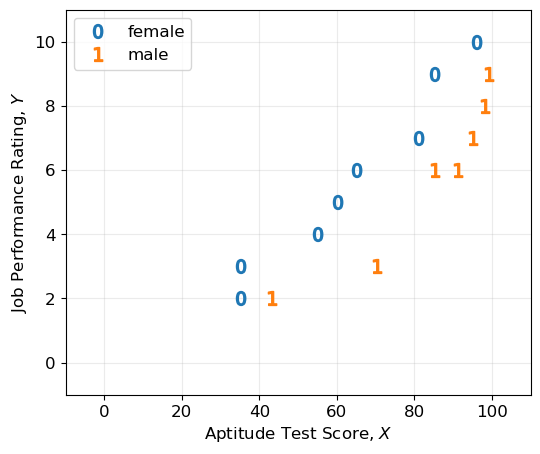

In [8]:
fig, ax = plt.subplots(figsize=(6,5))

x_female = df_scatter[df_scatter["X_2"] == 0]["X_1"].to_numpy()
y_female = df_scatter[df_scatter["X_2"] == 0]["Y"].to_numpy()

x_male = df_scatter[df_scatter["X_2"] == 1]["X_1"].to_numpy()
y_male = df_scatter[df_scatter["X_2"] == 1]["Y"].to_numpy()

ax.plot(x_female, y_female, marker=r'$0$', 
  markersize=10, linestyle="None", label="female")

ax.plot(x_male, y_male, marker=r"$1$", 
  markersize=10, linestyle="None", label="male")

ax.set_xlabel(r"Aptitude Test Score, $X$")
ax.set_ylabel(r"Job Performance Rating, $Y$")
ax.set_xlim([-10, 110])
ax.set_ylim([-1, 11])
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

## Fitted regression line

A fitted regression function has the form
$$
  \hat{Y} = b_0 + b_1 X_1 + b_2 X_2
$$
where
$$
\begin{align*}
  &X_1 = \text{the test score} \\
  &X_2 = \left\{
  \begin{aligned}
    &0 \text{ for females} \\
    &1 \text{ for males}
  \end{aligned}
  \right. \qquad \text{dummy variable}
\end{align*}
$$ 

The single equation above is equivalent to the following two equations:
$$
\begin{align*}
  &\hat{Y} = b_0 + b_1 X_1, &\text{for females}\\
  &\hat{Y} = b_0 + b_1 X_1 + b_2 = (b_0 + b_2) + b_1 X_1, &\text{for males}
\end{align*}
$$

One might envisage $X_2$ as a "switching" variable that is "on" when an observation is made for a male and "off" when it is made for a female.

In [9]:
regress, df_regress = get_multiple_regress_coeff(df_scatter, n_vars=2)

print(f"regress.intercept_ : {regress.intercept_}")
print(f"regress.coef_ : {regress.coef_}")
df_regress

regress.intercept_ : -1.9564709806537728
regress.coef_ : [ 0.12041361 -2.18071572]


,Subject,Y,X_1,X_2,hat_Y
0,1,5,60,0,5.268346
1,2,4,55,0,4.666278
2,3,3,35,0,2.258005
3,4,10,96,0,9.603235
4,5,2,35,0,2.258005
5,6,7,81,0,7.797031
6,7,6,65,0,5.870414
7,8,9,85,0,8.278686
8,9,9,99,1,7.783761
9,10,2,43,1,1.040598


### Several formulas to calculate values in Minitab's output


The following from is from [this link](https://stats.stackexchange.com/questions/173271/what-exactly-is-the-standard-error-of-the-intercept-in-multiple-regression-analy)
$$
  \textrm{std. err. of } b_i = s_{y\cdot x's} \sqrt{\operatorname*{diag}\left((\mathbf{X}^\mathsf{T} \mathbf{X})^{-1}\right)}
$$

where $\operatorname*{diag}(\mathbf{A})$ is an operator to take only the diagonal elements of a matrix $\mathbf{A}$.    
The matrix $\mathbf{X}$ is a $(n\times k)$ matrix where $n$ is the number of observation and $k$ is the number of independent (predictor) variables. This matrix has the explicit form:
$$
  \mathbf{X}
  = \begin{bmatrix}
    1 & X_{1, 1} & X_{1, 2} & \ldots & X_{1, k} \\
    1 & X_{2, 1} & X_{2, 2} & \ldots & X_{2, k} \\
      & \vdots   &          &        & \vdots   \\
    1 & X_{n, 1} & X_{n, 2} & \ldots & X_{n, k}
  \end{bmatrix}
$$

In [40]:
column_name = ["Ratings", "Test", "Gender"]
out_dict = get_minitab_out(df_regress, n_vars=2, new_column=column_name)

Correlations: Ratings, Test, Gender


,Ratings,Test
Test,0.88,1.00
Gender,0.02,0.43


Regression Analysis: Ratings versus Test, Gender


Predictor,Coef,SE Coef,T,P
Constant,-1.9565,0.7068,-2.77,0.015
Test,0.1204,0.0102,11.86,0.000
Gender,-2.1807,0.4503,-4.84,0.000


s_yxs = 0.7863   R_sq = 92.1%   R-sq(adj) = 90.8%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,2,86.981,43.491,70.349,0.000
Residual error,12,7.419,0.618,,
Total,14,94.400,,,


## Plot of regression model

In [11]:
x_female = df_scatter[df_scatter["X_2"] == 0]["X_1"].to_numpy()
y_female = df_scatter[df_scatter["X_2"] == 0]["Y"].to_numpy()

x_male = df_scatter[df_scatter["X_2"] == 1]["X_1"].to_numpy()
y_male = df_scatter[df_scatter["X_2"] == 1]["Y"].to_numpy()

regress = out_dict["regress"]
b0 = regress.intercept_
bk = regress.coef_

x_female_min = x_female.min()
x_female_max = x_female.max()
x_female_offset = 0.1*(x_female_max - x_female_min)
x_regress_female = np.array(
  [x_female_min - x_female_offset, x_female_max + x_female_max])
y_regress_female = b0 + bk[0]*x_regress_female + bk[1]*0

x_male_min = x_male.min()
x_male_max = x_male.max()
x_male_offset = 0.1*(x_male_max - x_male_min)
x_regress_male = np.array(
  [x_male_min - x_male_offset, x_male_max + x_male_max])
y_regress_male = b0 + bk[0]*x_regress_male + bk[1]*1

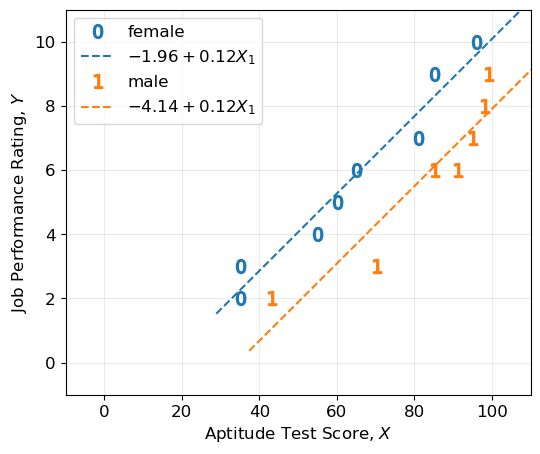

In [12]:
fig, ax = plt.subplots(figsize=(6,5))


data_handler = ax.plot(x_female, y_female, marker=r'$0$', 
  markersize=10, linestyle="None", label="female")
color = data_handler[0]._color
ax.plot(x_regress_female, y_regress_female, color=color, 
  linestyle="--", label=r"${:.2f} + {:.2f}X_1$".format(b0, bk[0]))

data_handler = ax.plot(x_male, y_male, marker=r"$1$", 
  markersize=10, linestyle="None", label="male")
color = data_handler[0]._color
ax.plot(x_regress_male, y_regress_male, color=color, 
  linestyle="--", label=r"${:.2f} + {:.2f}X_1$".format(b0 + bk[1], bk[0]))

ax.set_xlabel(r"Aptitude Test Score, $X$")
ax.set_ylabel(r"Job Performance Rating, $Y$")
ax.set_xlim([-10, 110])
ax.set_ylim([-1, 11])
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)


## Interpretation of the regression line equation

The regression coefficient value $b_1 = 0.12$, 
which is the slope of each of the lines, 
is the estimated average incerase in performance rating 
for each one-unit increase in aptitude test score. 
This coefficient applies to both males and females.

The other regression coefficient, $b_2 = -2.18$, 
applies only to males. For a male test taker, 
the estimated job performance rating is reduced, 
relative to female test takers, by $2.18 (= b_2)$ units 
when the aptitude score is held constant.

The mean job performance ratings were approximately equal for
males, $\overline{Y}_M = 5.86$, and females, $\overline{Y}_F = 5.75$. 
However, the males scored significantly higher ($\overline{X}_{1,M} = 83$) 
on the aptitude test than did the females ($\overline{X}_{1,F} = 64$). 
Therefore, if two applicants, one male and one female, took the aptitude test 
and both scored $70$, the female's estimated job performance rating
would be $2.18$ ($b_2$) points higher than the male's, since

### Difference of job performance at specific the score of aptitude test

In [30]:
X_1_atPoint = 70   # the aptitude test score for both male and female

hat_Y_female = b0 + bk[0]*X_1_atPoint
hat_Y_male = (b0 + bk[1]) + bk[0]*X_1_atPoint

print(f"performance rating difference: {hat_Y_female - hat_Y_male:.2f}")

performance rating difference: 2.18


### Correlation and Coefficient of determination $R^2$

A strong linear relationship exists between job performance and the aptitude test because

In [38]:
corr_matrix = out_dict["corr_matrix"]

r_Y_X_1 = corr_matrix[0, 0]
print(f"r_Y_X_1: {r_Y_X_1:.3f}")

r_Y_X_1: 0.876


If the aptitude test score ($X_1$) alone were used to predict performance, it would explain about 

In [49]:
R_sq_X_1 = r_Y_X_1**2 
print(f"R_sq_X_1 = {round(R_sq_X_1, 2)*100:.0f}%", end="")
print(" of the variation in job performance scores (Y)")

R_sq_X_1 = 77% of the variation in job performance scores (Y)


The correlation coefficient  

In [53]:
r_X_2_Y = corr_matrix[1, 0]
print(f"r_X_2_Y = {r_X_2_Y:.2f}", end="")
print(" indicates virtually no relationship between" + 
  " gender (X_2) and job performance (Y)")

r_X_2_Y = 0.02 indicates virtually no relationship between gender (X_2) and job performance (Y)


This conclusion is also evident from the fact that the mean performance
ratings for males and females are nearly equal ($\overline{Y}_M = 5.85$ and 
$\overline{Y}_F = 5.75$).   
At first glance, one might conclude that knowledge of whether an applicant 
is male or female is not useful information.     
However, the moderate relationship 

In [55]:
r_X_2_X_1 = corr_matrix[1, 1]
print(f"r_X_2_X_1 =  {r_X_2_X_1:.2f}%")

r_X_2_X_1 =  0.43%


between gender ($X_2$) and aptitude test score ($X_1$) indicates that the test 
might discriminate between sexes.    
Males seems to do better on the test than do females ($\overline{X}_M = 83$ 
versus $\overline{X}_F = 64$).    
Perhaps some element of strength is required on the test that is not required   
on the job.



When both test results and gender are used to forecast job performance, 
92% ($R^2$) of the variance is explained by the regression model. 
This result suggests that both variables make a valuable contribution
to predicting performance. The aptitude test scores explain 77% of the variance,
and gender used in conjuction with the aptitude test scores add 
another (99% - 77% = 15%).  
The computed $t$ statistics, for $t_{X_1} = 11.86$ ($p$-value = .000) 
and for $t_{X_2} = -4.84$ ($p$-value = .000), 
for aptitude test score and gender, respectively, indicate that both 
predictor variables should be included in the final regression function.